In [ ]:
# E1: It is importaint to make sure the feature ranges are all on the same scale since the goal is to cluster high density regions separated from the others 
#     having all features on the same scale helps distiguish these clusters
# E2: A
# E3: There is no guarantee of finding a global minimum, a very high number of iterations to find the centriods is not uncommon. It also requires to predefine the number 
#     of expected clusters, so on data we dont know much about and/or is high dimentional this could be a disadvantage

In [22]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

s3 = boto3.resource('s3')
bucket_name = 'grant-gonnerman-data-445'
bucket = s3.Bucket(bucket_name)

file_key = 'Mall_Customers.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading data file
customers = pd.read_csv(file_content_stream)
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [23]:
customers['Gender'].replace(['Male', 'Female'], [1, 0], inplace = True)
customers = customers[['Gender', 'Age', 'Annual Income (k$)']]
customers.head()

,Gender,Age,Annual Income (k$)
0,1,19,15
1,1,21,15
2,0,20,16
3,0,23,16
4,0,31,17


In [24]:
# scaling the data
scaler = MinMaxScaler()
customers[['Gender_01', 'Age_01', 'Annual Income(k$)_01']] = scaler.fit_transform(customers)
customers.head()

,Gender,Age,Annual Income (k$),Gender_01,Age_01,Annual Income(k$)_01
0,1,19,15,1.0,0.019231,0.000000
1,1,21,15,1.0,0.057692,0.000000
2,0,20,16,0.0,0.038462,0.008197
3,0,23,16,0.0,0.096154,0.008197
4,0,31,17,0.0,0.250000,0.016393


In [31]:
## list to store silhouette score
silouette = list()
calinski = list()
davies = list()

for i in range(2,11):
    #clustering the data
    kmeans_md = KMeans(n_clusters = i, n_init = 20).fit(customers[['Gender_01', 'Age_01', 'Annual Income(k$)_01']])
    kmeans_labels = kmeans_md.labels_
    
    #computing silhouette score
    s_score = silhouette_score(customers[['Gender_01', 'Age_01', 'Annual Income(k$)_01']], kmeans_labels)
    silouette.append(s_score)
    
    #computing silhouette score
    c_score = calinski_harabasz_score(customers[['Gender_01', 'Age_01', 'Annual Income(k$)_01']], kmeans_labels)
    calinski.append(c_score)
    
    #computing silhouette score
    d_score = davies_bouldin_score(customers[['Gender_01', 'Age_01', 'Annual Income(k$)_01']], kmeans_labels)
    davies.append(d_score)

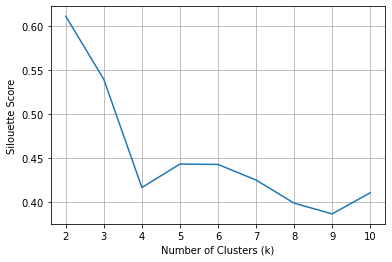

In [32]:
plt.plot(range(2,11), silouette)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silouette Score')
plt.grid()
plt.show()

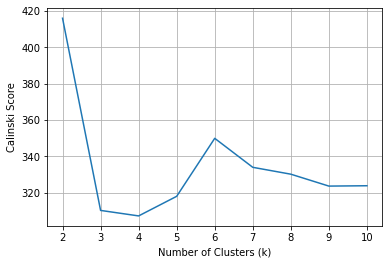

In [33]:
plt.plot(range(2,11), calinski)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski Score')
plt.grid()
plt.show()

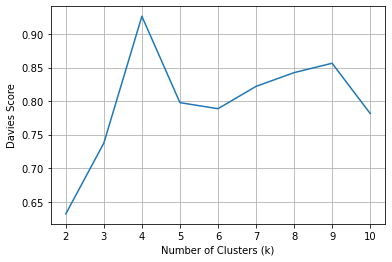

In [34]:
plt.plot(range(2,11), davies)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies Score')
plt.grid()
plt.show()

In [ ]:
# from the charts above we can see the silouette and calinski scores estimate 2 clusters while davies estimated 4. i will move forward with 2 since that is the majority

In [35]:
#clustering data
two_clusters = KMeans(n_clusters = 2, n_init = 20).fit(customers[['Gender_01', 'Age_01', 'Annual Income(k$)_01']])

#append data
customers['cluster'] = two_clusters.labels_
customers.head()

,Gender,Age,Annual Income (k$),Gender_01,Age_01,Annual Income(k$)_01,cluster
0,1,19,15,1.0,0.019231,0.000000,0
1,1,21,15,1.0,0.057692,0.000000,0
2,0,20,16,0.0,0.038462,0.008197,1
3,0,23,16,0.0,0.096154,0.008197,1
4,0,31,17,0.0,0.250000,0.016393,1


In [36]:
cluster_0 = customers[customers['cluster'] == 0]
cluster_0.describe()

,Gender,Age,Annual Income (k$),Gender_01,Age_01,Annual Income(k$)_01,cluster
count,88.0,88.000000,88.000000,88.0,88.000000,88.000000,88.0
mean,1.0,39.806818,62.227273,1.0,0.419362,0.387109,0.0
std,0.0,15.514812,26.638373,0.0,0.298362,0.218347,0.0
min,1.0,18.000000,15.000000,1.0,0.000000,0.000000,0.0
25%,1.0,27.750000,45.500000,1.0,0.187500,0.250000,0.0
50%,1.0,37.000000,62.500000,1.0,0.365385,0.389344,0.0
75%,1.0,50.500000,78.000000,1.0,0.625000,0.516393,0.0
max,1.0,70.000000,137.000000,1.0,1.000000,1.000000,0.0


In [37]:
cluster_0 = customers[customers['cluster'] == 1]
cluster_0.describe()

,Gender,Age,Annual Income (k$),Gender_01,Age_01,Annual Income(k$)_01,cluster
count,112.0,112.000000,112.000000,112.0,112.000000,112.000000,112.0
mean,0.0,38.098214,59.250000,0.0,0.386504,0.362705,1.0
std,0.0,12.644095,26.011952,0.0,0.243156,0.213213,0.0
min,0.0,18.000000,16.000000,0.0,0.000000,0.008197,1.0
25%,0.0,29.000000,39.750000,0.0,0.211538,0.202869,1.0
50%,0.0,35.000000,60.000000,0.0,0.326923,0.368852,1.0
75%,0.0,47.500000,77.250000,0.0,0.567308,0.510246,1.0
max,0.0,68.000000,126.000000,0.0,0.961538,0.909836,1.0


In [ ]:
# from the clusters we can see there is a male and female cluster, the age and income features are both relativaly similar. 
# male cluster being about 1.8 older and 3 larger income on average.
# based on the data these clusters make sense.